In [1]:
!mkdir /kaggle/working/checkpoints

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import string
import re
import torchvision
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
import time

In [4]:
%load_ext cudf.pandas
import pandas as pd

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [6]:
INPUT_IMAGES_DIR = "/kaggle/input/flickr8kimagescaptions/flickr8k/images"
LABEL_PATH = "/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt"

UNK = "#UNK"
PAD = "#PAD"
START = "#START"
END = "#END"

In [7]:
df = pd.read_csv(LABEL_PATH)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [8]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
def clean_text(row):
    row = str(row).strip()
    row = row.lower()
    return regex.sub("", row)

In [9]:
df.columns = [col.strip() for col in df.columns]
df["caption"] = df["caption"].apply(clean_text)

In [10]:
df["length"] = df["caption"].apply(lambda row: len(row.strip().split()))

(array([6.7700e+02, 7.2360e+03, 1.7093e+04, 9.3120e+03, 4.7610e+03,
        9.4600e+02, 3.4700e+02, 5.4000e+01, 2.5000e+01, 4.0000e+00]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <BarContainer object of 10 artists>)

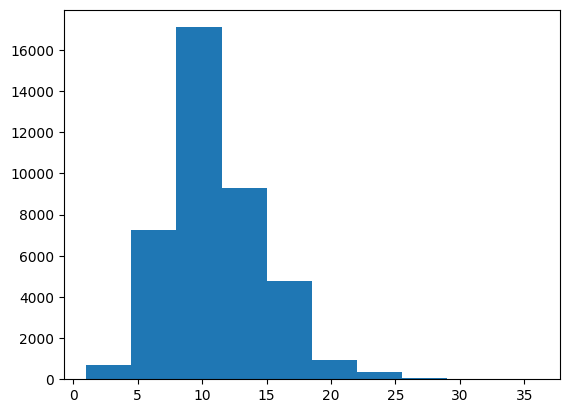

In [11]:
plt.hist(df['length'])

In [12]:
captions = df["caption"].tolist()

In [13]:
word_freq = {}
for caption in captions:
    caption = caption.strip()
    for word in caption.split():
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

In [14]:
dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:10])

{'a': 62986,
 'in': 18974,
 'the': 18418,
 'on': 10743,
 'is': 9345,
 'and': 8851,
 'dog': 8136,
 'with': 7765,
 'man': 7265,
 'of': 6713}

In [15]:
def build_vocab(captions, word_freq, count_threshold=5):
    vocab = {
        PAD: 0,
        UNK: 1,
        START: 2,
        END: 3
    }
    index = 4
    
    for caption in captions:
        caption = caption.strip().split(" ")
        for word in caption:
            if word and word_freq[word] >= count_threshold and word not in vocab:
                vocab[word] = index
                index += 1

    inv_vocab = {v: k for k, v in vocab.items()}
    return vocab, inv_vocab

In [16]:
vocab, inv_vocab = build_vocab(captions, word_freq)

In [17]:
def convert_captions(captions, vocab, max_length=30):
    tokens = [[vocab[PAD]]*max_length for _ in range(len(captions))]
    for i, caption in enumerate(captions):
        caption = caption.strip().split()
        tokens[i][0] = vocab[START]
        j = 1
        for word in caption[:max_length-2]:
            if word not in vocab:
                tokens[i][j] = vocab[UNK]
            else:
                tokens[i][j] = vocab[word]
            j += 1
        tokens[i][j] = vocab[END]
    return tokens

In [18]:
tokens = convert_captions(captions, vocab)
img_paths = list(df["image"])

In [19]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_paths, tokens):
        self.img_paths = [os.path.join(INPUT_IMAGES_DIR, p) for p in img_paths][:-20000]
        self.tokens = tokens[:-20000]
        assert len(self.img_paths) == len(self.tokens)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        token = self.tokens[index]
        img = cv2.imread(img_path)
        img = self._resize_img(img, shape=(300, 300))
        img = torchvision.transforms.ToTensor()(img)
        token = torch.as_tensor(token)
        return img, token
    
    def __len__(self):
        return len(self.img_paths)

    def _resize_img(self, img, shape=(300, 300)):
        h, w = img.shape[0], img.shape[1]
        pad_left = 0
        pad_right = 0
        pad_top = 0
        pad_bottom = 0
        if h > w:
            diff = h - w
            pad_top = diff - diff // 2
            pad_bottom = diff // 2
        else:
            diff = w - h
            pad_left = diff - diff // 2
            pad_right = diff // 2
        cropped_img = img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]
        cropped_img = cv2.resize(cropped_img, shape)
        return cropped_img

In [20]:
dataset = ImageCaptioningDataset(img_paths, tokens)

In [21]:
MAX_LENGTH = 26
NUM_VOCAB = len(vocab)
BATCH_SIZE = 21
EPOCH = 5

In [22]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

In [23]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

In [24]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out

In [25]:
def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)

In [26]:
model_dict = {
    'resnet18': [resnet18, 512],
    'resnet34': [resnet34, 512],
    'resnet50': [resnet50, 2048],
    'resnet101': [resnet101, 2048],
}

In [27]:
class ResNetEncoder(nn.Module):
    """ResNet-based encoder for image captioning."""
    def __init__(self, name='resnet34'):
        super(ResNetEncoder, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])
        
        # Adaptive pooling to get fixed feature size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_dim = dim_in

    def forward(self, x):
        features = self.encoder(x)  # Extract feature maps
        features = self.avgpool(features)  # Pool to fixed size
        features = torch.flatten(features, 1)  # Flatten to (batch_size, feature_dim)
        
        return features


In [28]:
class RNNDecoder(nn.Module):

    def __init__(self, num_vocab) -> None:
        super().__init__()
        self.bottleneck = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU()
        )
        self.num_vocab = num_vocab
        self.embedding = nn.Embedding(num_embeddings=num_vocab, embedding_dim=256, padding_idx=0)
        self.num_layers = 1
        self.bidirectional = False
        self.rnn = nn.LSTM(input_size=256, hidden_size=256, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_vocab)
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input, img_embeded, prediction=False):
        img_embeded = self.bottleneck(img_embeded)
        img_embeded = torch.stack([img_embeded]*(self.num_layers), dim=0)
        if prediction:
            output = []
            hidden = (img_embeded, img_embeded)
            out = input
            # print('decoder forward check 3')
            while out != vocab[END] and len(output) <= MAX_LENGTH:
                out = torch.tensor([[out]]).to("cuda")
                out = self.embedding(out)
                out, hidden = self.rnn(out, hidden)
                out = self.classifier(out)
                out = self.softmax(out)
                out = torch.argmax(out, dim=-1)
                out = out.squeeze().item()
                output.append(out)
        else:
            input = self.embedding(input)
            output, (h, c) = self.rnn(input, (img_embeded, img_embeded))
            output = self.classifier(output)
        return output

In [29]:
class ImageCaptioningModel:

    def __init__(self, encoder : ResNetEncoder, decoder : RNNDecoder, train_dataset : ImageCaptioningDataset):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.encoder = encoder.to(self.device)
        self.encoder.eval()
        self.decoder = decoder.to(self.device)
        self.train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        self.optimizer = optim.Adam(decoder.parameters())
        self.loss = nn.CrossEntropyLoss()

    def predict(self, img):
        self.encoder.eval()
        self.decoder.eval()
        # print("Predict method called!")
        
        with torch.no_grad():
            if img.dim() == 3:
                img = img.unsqueeze(0)  # Ensure batch dimension
            img = img.to(self.device)
    
            img_embed = self.encoder(img)
            # print("Image embedding shape:", img_embed.shape)
    
            caption = [vocab[START]]
            
            # FIX: Ensure hidden state has correct batch dimensions
            hidden = (
                self.decoder.bottleneck(img_embed).unsqueeze(0),
                self.decoder.bottleneck(img_embed).unsqueeze(0)
            )
    
            for _ in range(MAX_LENGTH):
                inp = torch.tensor([[caption[-1]]]).to(self.device)
                inp = self.decoder.embedding(inp)
                out, hidden = self.decoder.rnn(inp, hidden)  # Now hidden is 3D
                out = self.decoder.classifier(out)
    
                # print("Raw output logits shape:", out.shape)
    
                out = F.softmax(out, dim=-1)
                # print("Softmax output shape:", out.shape)
                # print("Softmax probabilities:", out.squeeze().cpu().numpy())
    
                out = torch.argmax(out, dim=-1).item()
                # print("Chosen token index:", out)
    
                if out == vocab[END]:
                    break
                caption.append(out)
    
            text = [inv_vocab[t] for t in caption]
            return " ".join(text)


    def train(self):
        self.encoder.train()
        self.decoder.train()
        for e in range(EPOCH):
            pbar = tqdm(self.train_dataloader, desc="Epoch: {}".format(e+1))
            for i, (img, caption) in enumerate(pbar):
                img = img.to(self.device)
                caption = caption.to(self.device)
                img_embed = self.encoder(img)
                output = self.decoder(caption[:, :-1], img_embed)
                output = output.permute(0, 2, 1)
                loss = self.loss(output, caption[:, 1:])

                self.optimizer.zero_grad()
                loss.backward() 
                self.optimizer.step()

                pbar.set_description(desc="Epoch " + str(e+1) + " - Loss: %.5f" % (loss.item()))
                if (i + 1) % 5 == 0:
                    torch.save(self.decoder.state_dict(), "/kaggle/working/checkpoints/decoder_checkpoint.pth")
                    torch.save(self.encoder.state_dict(), "/kaggle/working/checkpoints/encoder_checkpoint.pth")
                # if ((i+1)%10) == 0:
                #     plt.imshow(img[-1].cpu().detach().numpy().transpose((1, 2, 0)))
                #     output = self.predict(img[-1].unsqueeze(0))
                #     plt.title(output)
                #     plt.show()

In [30]:
cnn = ResNetEncoder()
rnn = RNNDecoder(num_vocab=NUM_VOCAB)
model = ImageCaptioningModel(encoder=cnn, decoder=rnn, train_dataset=dataset)

In [31]:
torch.cuda.empty_cache()
model.train()

Epoch 5 - Loss: 2.69493: 100%|██████████| 975/975 [53:21<00:00,  3.28s/it]


In [33]:
from nltk.translate.bleu_score import sentence_bleu
import torch

class ImageCaptioningEvaluator:
    def __init__(self, model, dataset, vocab, inv_vocab):
        self.model = model
        self.dataset = dataset
        self.vocab = vocab
        self.inv_vocab = inv_vocab

    def evaluate(self, num_samples=100):
        bleu_scores = []

        for i in range(num_samples):
            img, true_caption = self.dataset[i]
            img = img.unsqueeze(0).to(self.model.device)
            generated_caption = self.model.predict(img)

            true_caption_words = [self.inv_vocab[t] for t in true_caption.tolist() if t not in {self.vocab[START], self.vocab[END]}]
            generated_caption_words = generated_caption.split()
            
            bleu = sentence_bleu([true_caption_words], generated_caption_words)
            bleu_scores.append(bleu)
        avg_bleu = sum(bleu_scores) / len(bleu_scores)
        print(f"BLEU Score: {avg_bleu:.4f}")

        return avg_bleu

In [70]:
evaluator = ImageCaptioningEvaluator(model, dataset, vocab, inv_vocab)
bleu_score = evaluator.evaluate(num_samples=2000)

BLEU Score: 0.2009


In [67]:
def show_prediction(index, show_picture=True, show_text=True):
    if(show_picture):
        img = cv2.imread('/kaggle/input/flickr8kimagescaptions/flickr8k/images/'+img_paths[index])
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    res = model.predict(dataset.__getitem__(index)[0].unsqueeze(0).to(device))
    return res

In [64]:
predictions = {}
for i in range(0, 20000, 5):
    predictions = {i : show_prediction(i, show_picture=False, show_text=False)}

In [65]:
unique_values = set(predictions.values())
print(unique_values)

{'#START a man in a red shirt is standing in front of a #UNK #UNK'}


In [76]:
len(captions)

40455

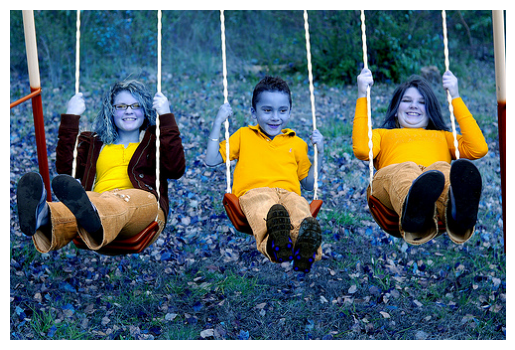

'#START a man in a red shirt is standing in front of a #UNK #UNK'

In [68]:
show_prediction(18899)

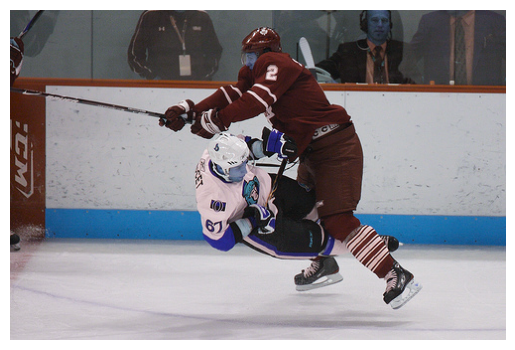

#START a man in a red shirt is standing in front of a #UNK #UNK


In [42]:
show_prediction(16000)

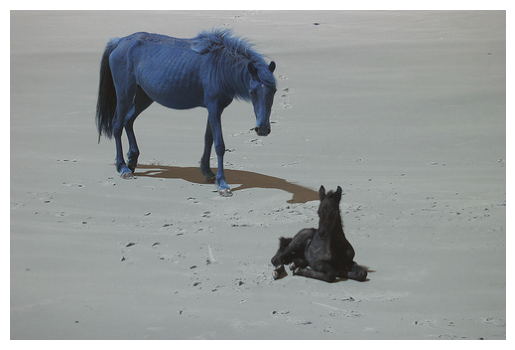

#START a man in a red shirt is standing in front of a #UNK #UNK


In [39]:
show_prediction(999)

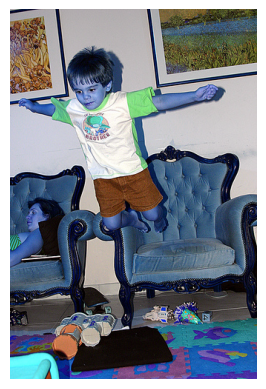

'#START a man in a red shirt is standing in front of a #UNK #UNK'

In [69]:
show_prediction(15099)

In [36]:
import os
files = os.listdir("/kaggle/working/checkpoints")
print(files)

['decoder_checkpoint.pth', 'encoder_checkpoint.pth']
